In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# To make sure we are using gpu not cpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger

import tensorflow as tf

import pickle

from sklearn.metrics import classification_report,confusion_matrix

In [5]:
datagen = ImageDataGenerator(rescale = 1./255)

In [6]:

train = datagen.flow_from_directory('/content/gdrive/My Drive/train/', target_size=(224, 224), class_mode='binary', batch_size=64)
# load and iterate validation dataset
val = datagen.flow_from_directory('/content/gdrive/My Drive/val/', target_size=(224, 224), class_mode='binary', batch_size=64)
# load and iterate test dataset
test = datagen.flow_from_directory('/content/gdrive/My Drive/test/', target_size=(224, 224), class_mode='binary', batch_size=64)

Found 3816 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.


In [7]:
imgs, labels = next(train)

In [8]:
imgs.shape

(64, 224, 224, 3)

In [9]:
train.class_indices


{'Benign': 0, 'Malignant': 1}

0.0


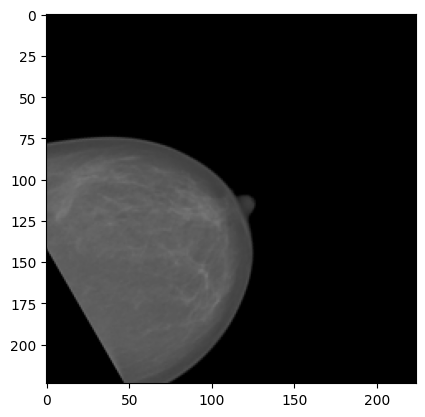

In [10]:
plt.imshow(imgs[0])
print(labels[0])

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
#https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,797,665 (10.67 MB)

 Trainable params: 2,797,665 (10.67 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
STEP_SIZE_TRAIN = train.n//train.batch_size
STEP_SIZE_VAL = val.n//val.batch_size

In [14]:
csv_logger = CSVLogger('/content/gdrive/My Drive/training.log', separator=',', append=False)

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [16]:
history = model.fit(
    train,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test,
    validation_steps=STEP_SIZE_VAL,
    epochs=25,
    callbacks=[csv_logger]
)

model.save('/content/gdrive/My Drive/first_model.h5')


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1754s 30s/step - accuracy: 0.6607 - loss: 0.6986 - val_accuracy: 0.6708 - val_loss: 0.6369
Epoch 2/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7500 - loss: 0.6032

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 452ms/step - accuracy: 0.7500 - loss: 0.6032 - val_accuracy: 0.6724 - val_loss: 0.6300
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 389ms/step - accuracy: 0.6816 - loss: 0.6352 - val_accuracy: 0.6681 - val_loss: 0.6411
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.6562 - loss: 0.6470 - val_accuracy: 0.6724 - val_loss: 0.6329
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 566ms/step - accuracy: 0.6726 - loss: 0.6382 - val_accuracy: 0.6719 - val_loss: 0.6245
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.6719 - loss: 0.6279 - val_accuracy: 0.6719 - val_loss: 0.6252
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - accuracy: 0.6561 - loss: 0.6405 - val_accuracy: 0.6676 - val_loss: 0.6220
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.5781 - loss: 0.7188 - val_accuracy: 0.6719 - val_loss: 0.6340
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.6706 - loss: 0.6229 - val_accuracy: 0.6703

In [17]:
import pandas as pd
log_data = pd.read_csv('/content/gdrive/My Drive/training.log', sep=',', engine='python')

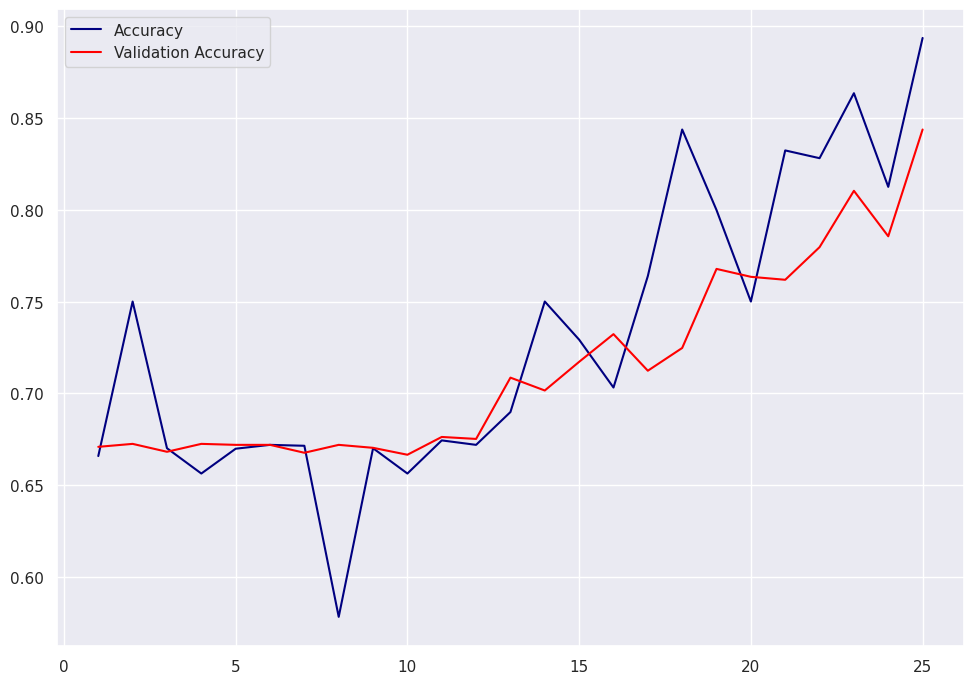

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(history.history['accuracy'])+1,1), history.history['accuracy'], color='navy', label = 'Accuracy')
plt.plot(np.arange(1, len(history.history['accuracy'])+1,1), history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.legend()

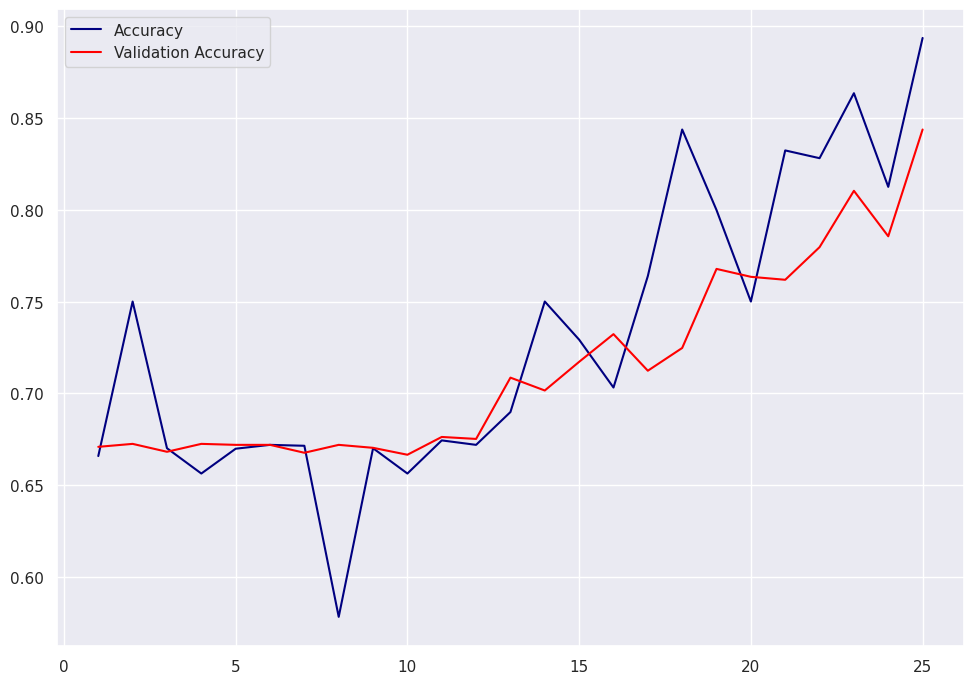

In [19]:
# show the accuracy graph from the saved history (log_data)
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(log_data['accuracy'])+1,1), log_data['accuracy'], color='navy', label = 'Accuracy')
plt.plot(np.arange(1, len(log_data['accuracy'])+1,1), log_data['val_accuracy'], color='red', label='Validation Accuracy')
plt.legend()

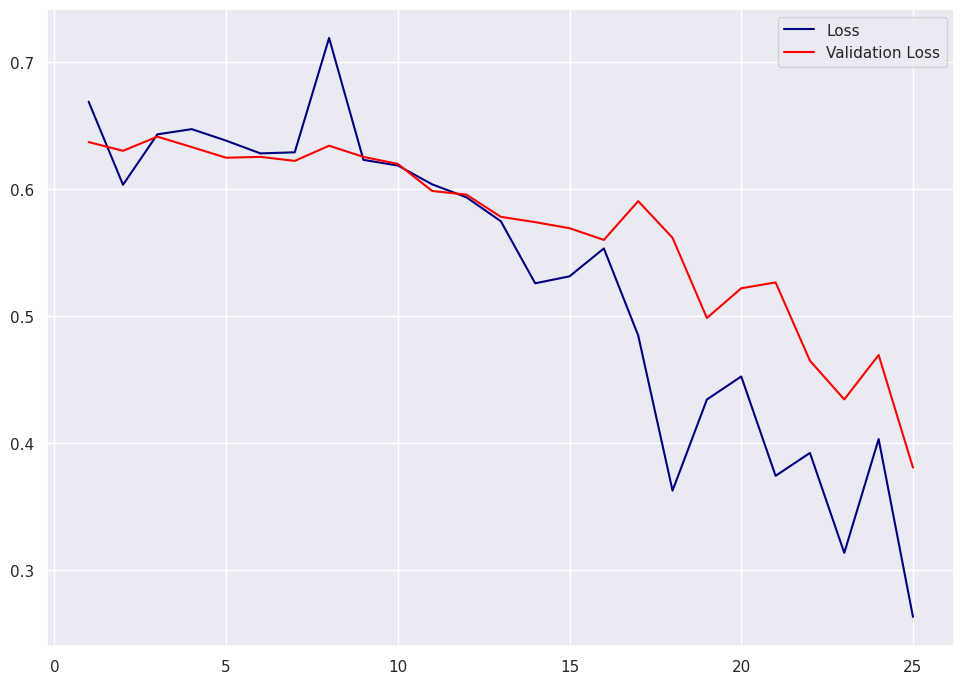

In [20]:
plt.plot(np.arange(1, len(history.history['loss'])+1,1), history.history['loss'], color='navy', label = 'Loss')
plt.plot(np.arange(1, len(history.history['loss'])+1,1), history.history['val_loss'], color='red', label='Validation Loss')
plt.legend()

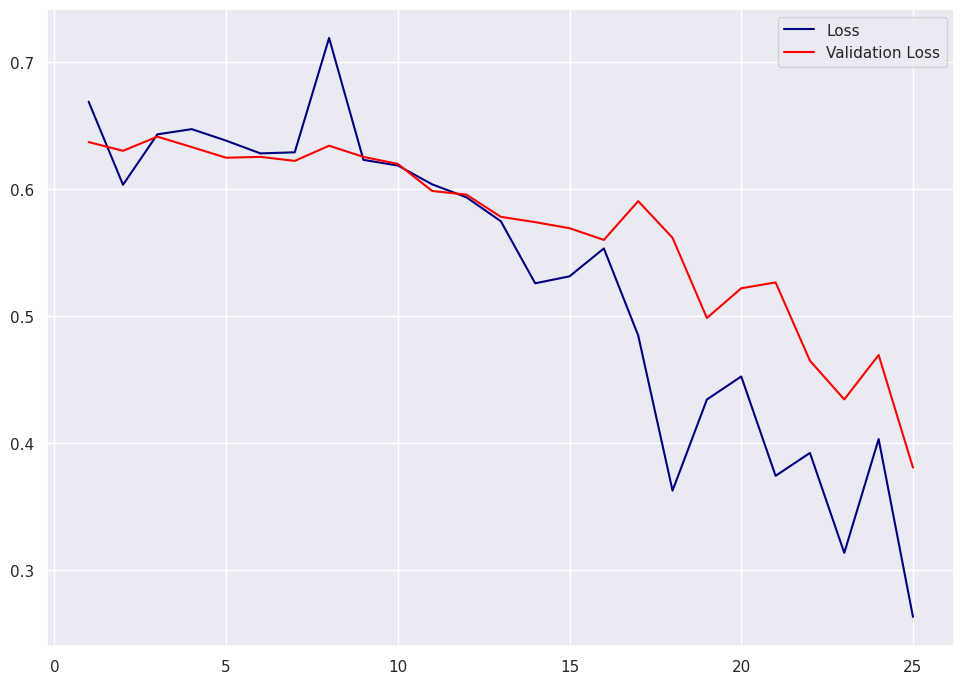

In [21]:
# show the loss graph from the saved history (log_data)

plt.plot(np.arange(1, len(log_data['loss'])+1,1), log_data['loss'], color='navy', label = 'Loss')
plt.plot(np.arange(1, len(log_data['loss'])+1,1), log_data['val_loss'], color='red', label='Validation Loss')
plt.legend()

In [22]:
from keras.models import load_model

restored_model = load_model('/content/gdrive/My Drive/first_model.h5')

In [24]:
steps = test.n // test.batch_size

test.reset()
X_test, y_test = [], []
for i in range(steps):
    a, b = next(test)   # ✅ use next() instead of test.next()
    X_test.extend(a)
    y_test.extend(b)


In [25]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [26]:
pickle.dump(X_test, open('/content/gdrive/My Drive/X_test.pkl', 'wb'))
pickle.dump(y_test, open('/content/gdrive/My Drive/y_test.pkl', 'wb'))

In [27]:
X_test = pickle.load(open('/content/gdrive/My Drive/X_test.pkl', 'rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/y_test.pkl', 'rb'))

In [28]:
print(X_test.shape, y_test.shape)

(1856, 224, 224, 3) (1856,)


In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.3829256594181061 / Test accuracy: 0.8415948152542114


In [30]:
# Using the saved model
score = restored_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.3829256594181061 / Test accuracy: 0.8415948152542114


In [31]:
y_pred_prob = model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [32]:
# Using the saved model
y_pred_prob = restored_model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


In [33]:
y_pred_prob

array([[0.85347176],
       [0.10611771],
       [0.93247133],
       ...,
       [0.09481772],
       [0.5020089 ],
       [0.37214473]], dtype=float32)

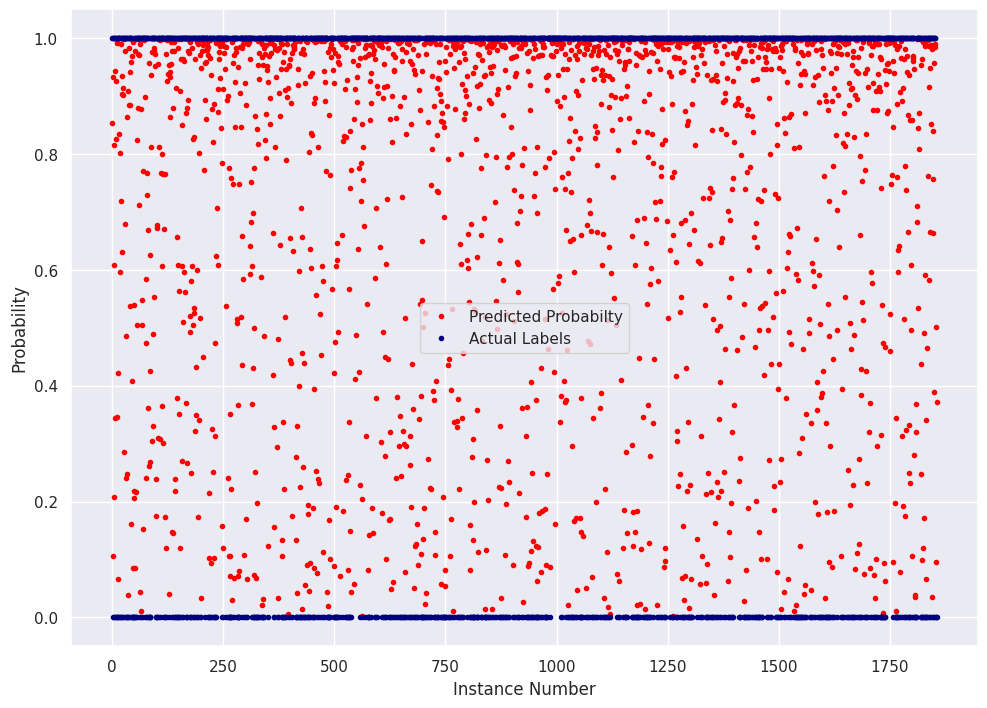

In [34]:
plt.plot(y_pred_prob,'.',color='red',label='Predicted Probabilty')
plt.plot(y_test,'.',color='navy',label='Actual Labels')
plt.xlabel('Instance Number')
plt.ylabel('Probability')
plt.legend()

In [35]:
y_test

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [36]:
threshold = 0.5
y_pred = np.where(y_pred_prob > threshold, 1,0)
y_pred.squeeze()

array([1, 0, 1, ..., 0, 1, 0])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

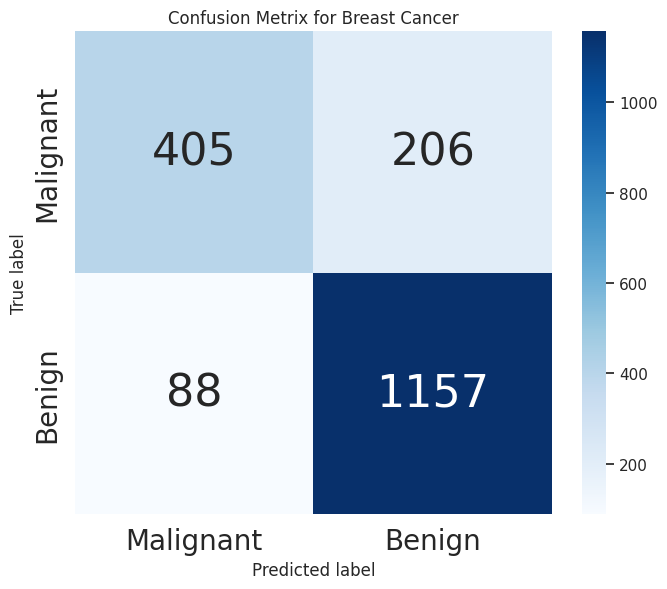

In [37]:
from sklearn.metrics import confusion_matrix

sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [38]:
print(classification_report(y_test, y_pred, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.82      0.66      0.73       611
Malignant (Class 1)       0.85      0.93      0.89      1245

           accuracy                           0.84      1856
          macro avg       0.84      0.80      0.81      1856
       weighted avg       0.84      0.84      0.84      1856



In [39]:
from sklearn.metrics import roc_curve, auc

fpr , tpr , thresholds = roc_curve (y_test , y_pred_prob)

area_under_curve = auc(fpr, tpr)

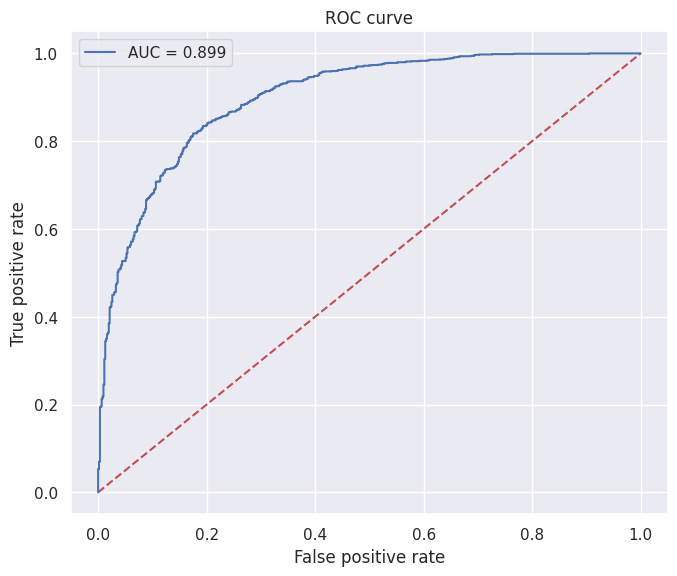

In [40]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [41]:
cancer_labels = ['Benign','Malignant']

img_indices = np.random.randint(0, len(X_test), size=[25])
sample_test_images = X_test[img_indices]
sample_test_labels = [cancer_labels[i] for i in y_pred[img_indices].squeeze()]

max_prediction = np.argmax(y_pred_prob, axis=1)
prediction_probs = np.max(y_pred_prob, axis=1)

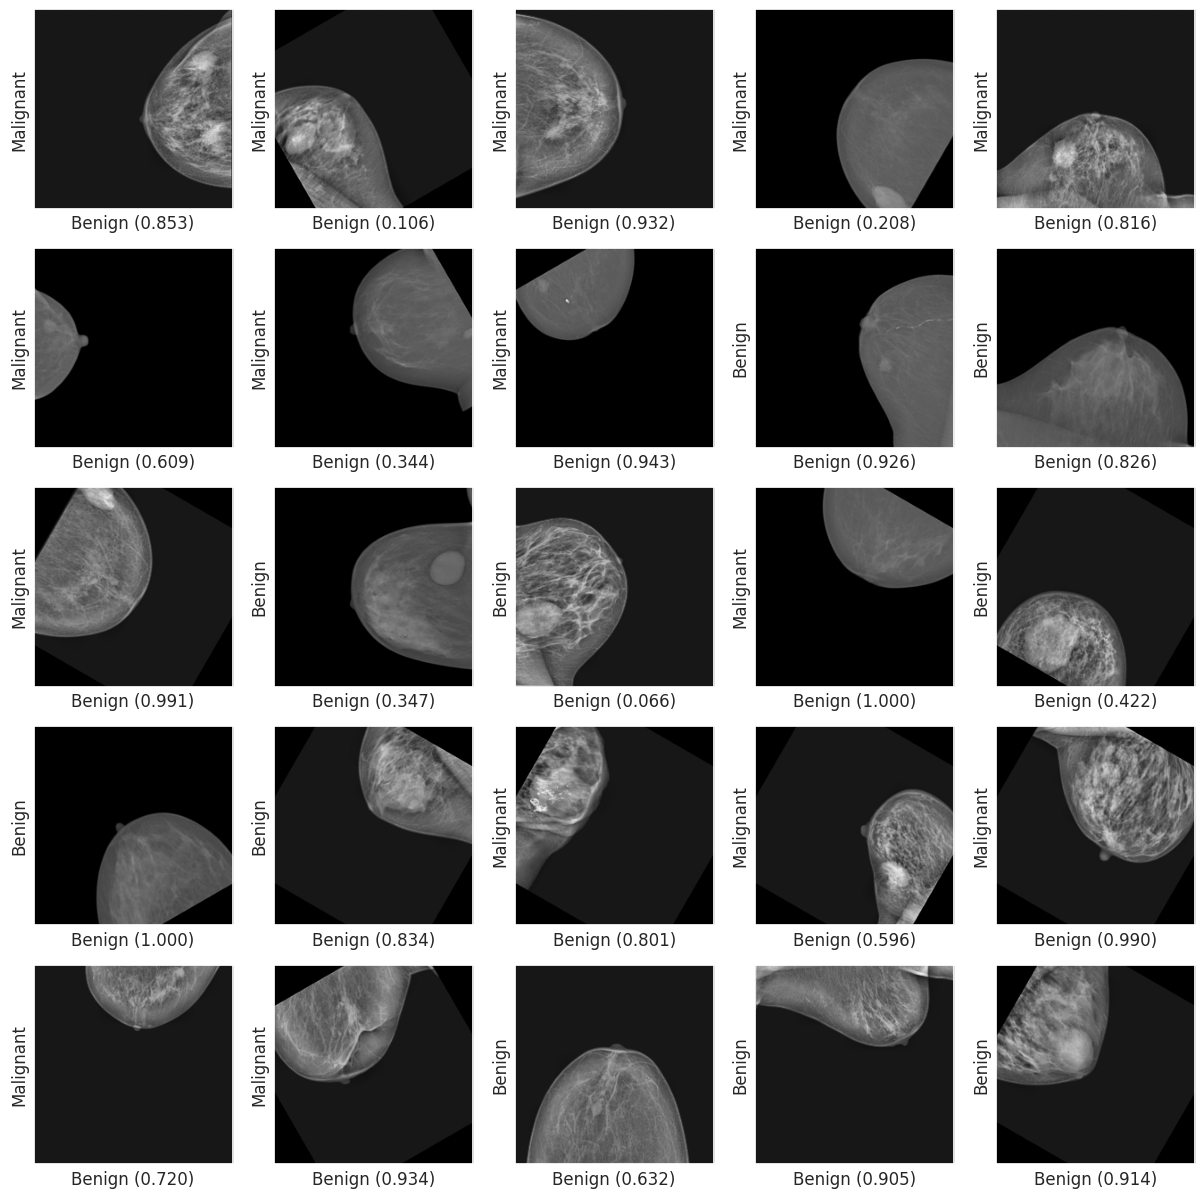

In [42]:
plt.figure(figsize=(15,15))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cancer_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))


# Transfer Learning using VGG16

## Feature Extraction (freezing the convolutional bases)

In [43]:
from keras.applications.vgg16 import VGG16

backbone = VGG16(input_shape = (224, 224, 3), include_top=False, weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [44]:
backbone.trainable = False

In [45]:
VGG_model = Sequential()
VGG_model.add(backbone)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())
VGG_model.add(Dropout(0.5))
VGG_model.add(Dense(1, activation='sigmoid'))

In [46]:
VGG_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [47]:
VGG_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,817 (105.14 MB)

 Trainable params: 12,847,105 (49.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [49]:
# Checkpoint
filepath="weights.best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [51]:
history = VGG_model.fit(
    train,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test,
    validation_steps=STEP_SIZE_VAL,
    epochs=10
)

VGG_model.save('/content/gdrive/My Drive/VGG_model.h5')


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 72s 771ms/step - accuracy: 0.5654 - loss: 0.8226 - val_accuracy: 0.3314 - val_loss: 1.0951
Epoch 2/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.6875 - loss: 0.5157

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6875 - loss: 0.5157 - val_accuracy: 0.3330 - val_loss: 1.0944
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - accuracy: 0.6865 - loss: 0.6008 - val_accuracy: 0.3491 - val_loss: 0.9451
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.7969 - loss: 0.4271 - val_accuracy: 0.3502 - val_loss: 0.9344
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.7510 - loss: 0.5085 - val_accuracy: 0.5022 - val_loss: 0.7635
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.7344 - loss: 0.5295 - val_accuracy: 0.4989 - val_loss: 0.7638
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 692ms/step - accuracy: 0.7888 - loss: 0.4436 - val_accuracy: 0.5264 - val_loss: 0.7619
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.7500 - loss: 0.4918 - val_accuracy: 0.5183 - val_loss: 0.7738
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 461ms/step - accuracy: 0.8385 - loss: 0.3789 - val_accuracy: 0.6099 - 

In [52]:
VGG_model = load_model('/content/gdrive/My Drive/VGG_model.h5')

In [53]:
score1 = VGG_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score1[0]} / Test accuracy: {score1[1]}')

Test loss: 0.6715229153633118 / Test accuracy: 0.6179956793785095


In [54]:
y_pred_prob_2 = VGG_model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step


In [55]:
threshold = 0.5
y_pred_2 = np.where(y_pred_prob_2 > threshold, 1,0)
y_pred_2.squeeze()

array([0, 0, 1, ..., 0, 0, 0])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

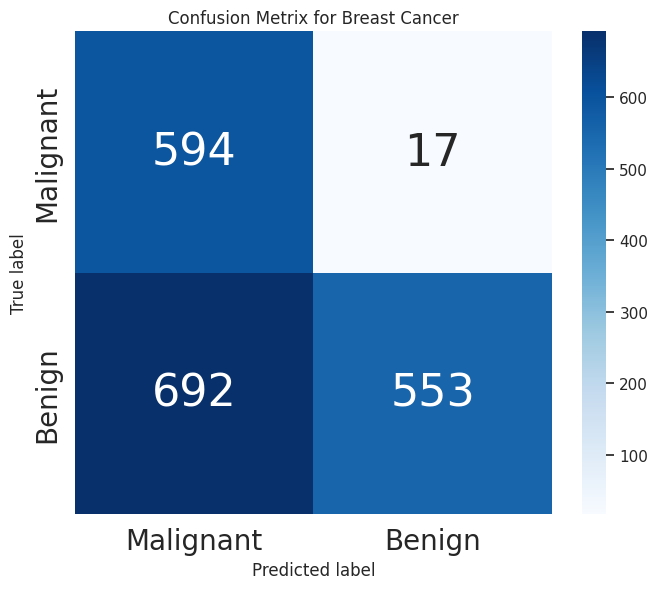

In [56]:
sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred_2),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [57]:
print(classification_report(y_test, y_pred_2, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.46      0.97      0.63       611
Malignant (Class 1)       0.97      0.44      0.61      1245

           accuracy                           0.62      1856
          macro avg       0.72      0.71      0.62      1856
       weighted avg       0.80      0.62      0.61      1856



## Fine Tuning

In [63]:
backbone2 = VGG16(input_shape = (224, 224, 3), include_top=False, weights='imagenet')

In [64]:
backbone.trainable = True

In [65]:
# Unfreeze final 2 convolution blocks

set_trainable = False
for layer in backbone2.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [66]:
VGG_model_2 = Sequential()
VGG_model_2.add(backbone2)
VGG_model_2.add(GlobalAveragePooling2D())
VGG_model_2.add(BatchNormalization())
VGG_model_2.add(Dropout(0.5))
VGG_model_2.add(Dense(1, activation='sigmoid'))

In [67]:
VGG_model_2.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [68]:
VGG_model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,249 (56.14 MB)

 Trainable params: 12,980,737 (49.52 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

In [70]:
history = VGG_model_2.fit(
    train,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test,
    validation_steps=STEP_SIZE_VAL,
    epochs=10
)

VGG_model_2.save('/content/gdrive/My Drive/VGG_model_2.h5')


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 74s 881ms/step - accuracy: 0.5786 - loss: 0.7113 - val_accuracy: 0.6099 - val_loss: 0.6665
Epoch 2/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 24s 430ms/step - accuracy: 0.8281 - loss: 0.4551

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.8281 - loss: 0.4551 - val_accuracy: 0.3518 - val_loss: 0.7166
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - accuracy: 0.7682 - loss: 0.5051 - val_accuracy: 0.7274 - val_loss: 0.5895
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.8594 - loss: 0.4274 - val_accuracy: 0.7554 - val_loss: 0.5813
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.8629 - loss: 0.3305 - val_accuracy: 0.7575 - val_loss: 0.4909
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.8281 - loss: 0.3742 - val_accuracy: 0.7699 - val_loss: 0.4883
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 68s 610ms/step - accuracy: 0.8829 - loss: 0.2919 - val_accuracy: 0.4898 - val_loss: 0.7541
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9375 - loss: 0.2314 - val_accuracy: 0.4165 - val_loss: 0.9976
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 71s 595ms/step - accuracy: 0.9198 - loss: 0.2020 - val_accuracy: 0.8675 -

In [71]:
VGG_model_2 = load_model('/content/gdrive/My Drive/VGG_model_2.h5')

In [72]:
score2 = VGG_model_2.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')

Test loss: 0.4122806191444397 / Test accuracy: 0.8081896305084229


In [73]:
y_pred_prob_3 = VGG_model_2.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step


In [74]:
threshold = 0.5
y_pred_3 = np.where(y_pred_prob_3 > threshold, 1,0)
y_pred_3.squeeze()

array([0, 0, 1, ..., 0, 0, 0])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

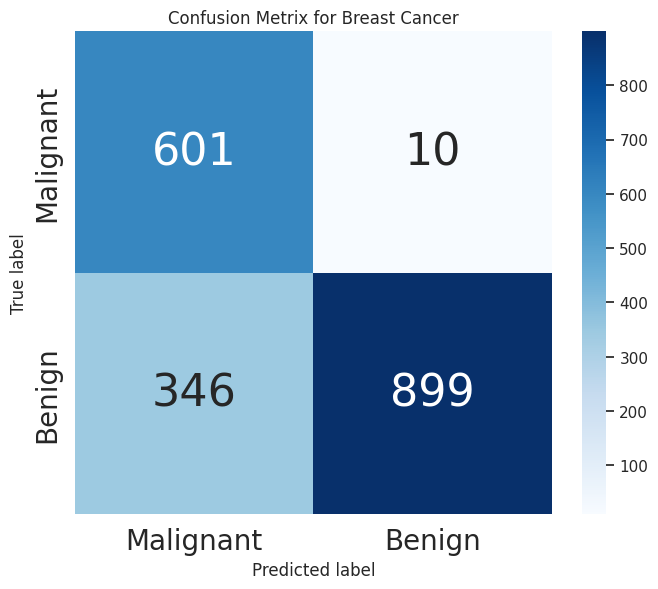

In [75]:
sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred_3),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [76]:
print(classification_report(y_test, y_pred_3, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.63      0.98      0.77       611
Malignant (Class 1)       0.99      0.72      0.83      1245

           accuracy                           0.81      1856
          macro avg       0.81      0.85      0.80      1856
       weighted avg       0.87      0.81      0.81      1856



# Transfer Learning using ResNet50

In [77]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [78]:
backbone3 = ResNet50(input_shape = (224, 224, 3), include_top=False, weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [79]:
backbone3.training = False

In [80]:
ResNet50_model = Sequential()
ResNet50_model.add(backbone3)
ResNet50_model.add(GlobalAveragePooling2D())
ResNet50_model.add(Dropout(0.5))
ResNet50_model.add(Dense(1, activation='sigmoid'))

In [81]:
ResNet50_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [82]:
ResNet50_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [84]:
history = ResNet50_model.fit(
    train,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test,
    validation_steps=STEP_SIZE_VAL,
    epochs=10
)

ResNet50_model.save('/content/gdrive/My Drive/ResNet50_model.h5')


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7042 - loss: 0.5960 - val_accuracy: 0.3297 - val_loss: 0.7428
Epoch 2/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 31s 535ms/step - accuracy: 0.9531 - loss: 0.1479

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9531 - loss: 0.1479 - val_accuracy: 0.3297 - val_loss: 0.7436
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 693ms/step - accuracy: 0.9639 - loss: 0.1125 - val_accuracy: 0.6670 - val_loss: 0.6538
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9688 - loss: 0.0572 - val_accuracy: 0.6713 - val_loss: 0.6523
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 847ms/step - accuracy: 0.9936 - loss: 0.0254 - val_accuracy: 0.6724 - val_loss: 0.6400
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 0.6681 - val_loss: 0.6424
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 693ms/step - accuracy: 0.9959 - loss: 0.0133 - val_accuracy: 0.6692 - val_loss: 0.6467
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.6686 - val_loss: 0.6469
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 846ms/step - accuracy: 0.9986 - loss: 0.0080 - val_accuracy: 0.6697 - 

In [85]:
ResNet50_model = load_model('/content/gdrive/My Drive/ResNet50_model.h5')

In [86]:
score3 = ResNet50_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score3[0]} / Test accuracy: {score3[1]}')

Test loss: 0.6473300457000732 / Test accuracy: 0.6713362336158752


In [87]:
y_pred_prob_4 = ResNet50_model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


In [88]:
threshold = 0.5
y_pred_4 = np.where(y_pred_prob_4 > threshold, 1,0)
y_pred_4.squeeze()

array([1, 1, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

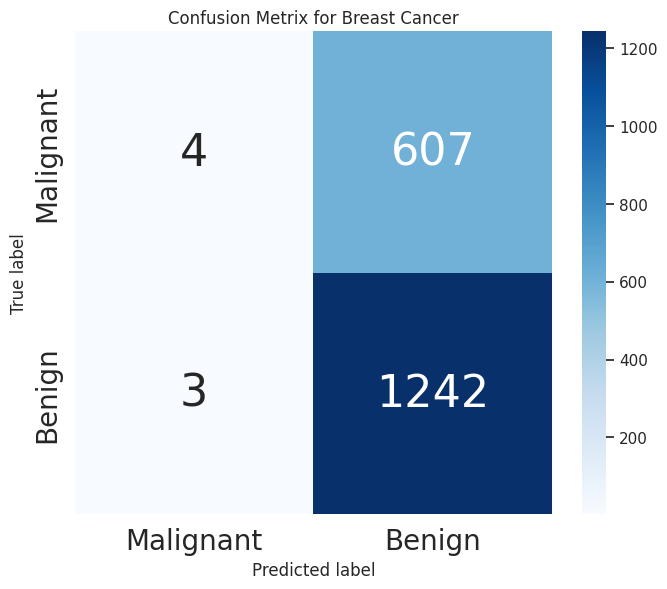

In [89]:
sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred_4),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [90]:
print(classification_report(y_test, y_pred_4, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.57      0.01      0.01       611
Malignant (Class 1)       0.67      1.00      0.80      1245

           accuracy                           0.67      1856
          macro avg       0.62      0.50      0.41      1856
       weighted avg       0.64      0.67      0.54      1856

